### Free Wilson Analysis

### Introduction
Free-Wilson Analysis provides a simple, intuitive means of evaluating a set of molecules, identifying substituents that contribute to, or detract from, activity, and locating potentially beneficial substituent combinations. For more information on the theory behind the method, check out [this](https://practicalcheminformatics.blogspot.com/2018/05/free-wilson-analysis.html) Practical Cheminformatics blog post.

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install pandas mols2grid scikit-learn seaborn useful_rdkit_utils numpy

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem.rdRGroupDecomposition import RGroupDecompose
from rdkit.Chem.TemplateAlign import AlignMolToTemplate2D
from rdkit.Chem.rdDepictor import Compute2DCoords
from rdkit.Chem import AllChem
import mols2grid
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
import seaborn as sns
from ipywidgets import interact
from itertools import product
import useful_rdkit_utils as uru
from tqdm.auto import tqdm
import numpy as np

### Data Input and Setup

Read the input data. That data is in a csv file with a header line and three columns, e.g. 
<pre>SMILES,Name,pIC50
Cc1ccc(C2CC3CCC(C2C(=O)OC(C)C)N3C)cc1,CHEMBL321806,5.99
Cc1ccc(C2CC3CCC(C2C(=O)Oc2ccccc2)N3C)cc1,CHEMBL340912,5.81
CN1C2CCC1C(C(=O)Oc1ccccc1)C(c1ccc(I)cc1)C2,CHEMBL340761,7.29
CC(C)OC(=O)C1C(c2ccc(I)cc2)CC2CCC1N2C,CHEMBL127546,7.9</pre>

In [2]:
input_filename = "https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/data/CHEMBL313_sel.smi"
df = pd.read_csv(input_filename)
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

Specify the core, note that R-groups don't have to be labeled. 

In [3]:
core_smiles = "c1ccc(C2CC3CCC(C2)N3)cc1"
core_mol = Chem.MolFromSmiles(core_smiles)

Generate coordinates for the core

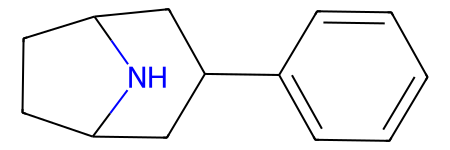

In [4]:
Compute2DCoords(core_mol)
core_mol

Align the molecules to core

In [5]:
for mol in df.mol:
    AllChem.GenerateDepictionMatching2DStructure(mol,core_mol)

View the molecules

In [6]:
mols2grid.display(df,mol_col='mol',use_coords=True, prerender=True, substruct_highlight=False)

MolGridWidget()

### R-Group Decomposition
Perform the R-group decomposition

In [7]:
match, miss = RGroupDecompose(core_mol,df.mol.values,asSmiles=True)
print(f"{len(miss)} molecules were not matched")
rgroup_df = pd.DataFrame(match)
rgroup_df

0 molecules were not matched


,Core,R1,R2,R3,R4,R5
0,c1c(C2CC3CCC(C2[*:3])N3[*:2])cc([*:4])c([*:5])...,[H][*:1],C[*:2],CC(C)OC(=O)[*:3],[H][*:4],C[*:5]
1,c1c(C2CC3CCC(C2[*:3])N3[*:2])cc([*:4])c([*:5])...,[H][*:1],C[*:2],O=C(Oc1ccccc1)[*:3],[H][*:4],C[*:5]
2,c1c(C2CC3CCC(C2[*:3])N3[*:2])cc([*:4])c([*:5])...,[H][*:1],C[*:2],O=C(Oc1ccccc1)[*:3],[H][*:4],I[*:5]
3,c1c(C2CC3CCC(C2[*:3])N3[*:2])cc([*:4])c([*:5])...,[H][*:1],C[*:2],CC(C)OC(=O)[*:3],[H][*:4],I[*:5]
4,c1c(C2CC3CCC(C2[*:3])N3[*:2])cc([*:4])c([*:5])...,[H][*:1],C[*:2],COC(=O)[*:3],[H][*:4],Br[*:5]
...,...,...,...,...,...,...
103,c1c(C2CC3CCC(C2[*:3])N3[*:2])cc([*:4])c([*:5])...,[H][*:1],[H][*:2],COC(=O)[*:3],[H][*:4],c1csc([*:5])n1
104,c1c(C2CC3CCC(C2[*:3])N3[*:2])cc([*:4])c([*:5])...,[H][*:1],C[*:2],COC(=O)[*:3],[H][*:4],c1cnc([*:5])cn1
105,c1c(C2CC3CCC(C2[*:3])N3[*:2])cc([*:4])c([*:5])...,[H][*:1],C[*:2],COC(=O)[*:3],[H][*:4],c1ncc([*:5])cn1
106,c1c(C2CC3CCC(C2[*:3])N3[*:2])cc([*:4])c([*:5])...,[H][*:1],C[*:2],COC(=O)[*:3],[H][*:4],c1ccc([*:5])nc1


Display the core(s) found by the R-group decomposition

In [8]:
core_df = pd.DataFrame({"mol" : [Chem.MolFromSmiles(x) for x in rgroup_df.Core.unique()]})
mols2grid.display(core_df,size=(300,200),mol_col="mol")

MolGridWidget()

### Collect Unique R-Groups
Create lists of unique R-groups

In [9]:
unique_list = []
for r in rgroup_df.columns[1:]:
    num_rgroups = len(rgroup_df[r].unique())
    print(r,num_rgroups)
    unique_list.append(rgroup_df[r].unique())
total_possible_products = np.prod([len(x) for x in unique_list])
print(f"{total_possible_products:,} products possible")

R1 8
R2 15
R3 18
R4 2
R5 31
133,920 products possible


### Build a Ridge Regression Model

Use a one hot encoder to encode R-groups into a bit string

In [10]:
enc = OneHotEncoder(categories=unique_list,sparse_output=False)
one_hot_mat = enc.fit_transform(rgroup_df.values[:,1:])

Split the data into training and test sets

In [11]:
train_X, test_X, train_y, test_y = train_test_split(one_hot_mat,df.pIC50)

1. Define a Ridge Regression model
2. Fit the model with the training set
3. Use the model to predict the test set

In [12]:
ridge = Ridge()
ridge.fit(train_X,train_y)
pred = ridge.predict(test_X)

### Visualize Model Performance

A few settings to make the plots look the way I want them to

In [13]:
sns.set(rc={'figure.figsize': (10, 10)})
sns.set_style('whitegrid')
sns.set_context('talk')

Visualize the model predictions

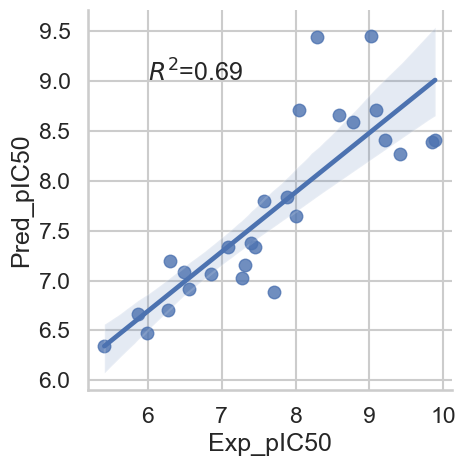

In [14]:
res_df = pd.DataFrame({'Exp_pIC50' : test_y, "Pred_pIC50": pred})
r2 = r2_score(test_y,pred)
fgrid = sns.lmplot(x='Exp_pIC50', y="Pred_pIC50", data=res_df)
ax = fgrid.axes[0,0]
ax.text(6,9,f"$R^2$={r2:.2f}");

### Associate Model Coefficients With R-Groups

View the coefficients associated with each R-group

In [15]:
ridge.coef_

array([ 0.16577135,  0.3092025 ,  0.01959575,  0.        ,  0.        ,
        0.07883941, -0.46010321, -0.1133058 ,  0.12505758,  1.04055584,
       -0.3218732 , -0.70030783,  0.        , -0.37628044,  0.        ,
        0.09112115, -0.34387885, -0.05387885,  0.39112115,  0.03112115,
        0.        , -0.25887885,  0.37612115, -0.0674182 , -0.49682401,
        0.78268094, -0.15016884, -0.19316744, -0.04016884,  0.63444248,
       -1.18222418,  0.61090793,  0.54156838,  0.01245993, -0.37628044,
       -0.06079391, -0.09316744,  0.        ,  0.        ,  0.37483116,
       -0.29667755, -0.02126548,  0.02126548, -0.9461368 ,  0.56365988,
        0.27342383, -0.4201396 , -1.02227071, -0.76257556,  0.68887764,
       -0.06345569,  1.04554431, -0.79721633, -0.2444672 ,  0.4355328 ,
       -0.8744672 , -0.15784028,  0.        ,  0.41278367,  0.        ,
        0.0654223 ,  0.0354223 , -0.5395777 ,  0.98539698,  0.77539698,
        0.        ,  0.4604223 ,  0.43873031,  0.5954223 ,  0.25

A function to align R-groups

In [16]:
def clear_sss_matches(mol_in):
    mol_in.__sssAtoms = []

class RGroupAligner:
    def __init__(self):
        self.ref_mol = Chem.MolFromSmarts("[#0]-[!#0]")
        Compute2DCoords(self.ref_mol)
        _ = self.ref_mol.GetConformer(0)
        
    def align(self,mol_in):
        Compute2DCoords(mol_in)
        _ = mol_in.GetConformer(0)
        AlignMolToTemplate2D(mol_in,self.ref_mol,clearConfs=True)
        clear_sss_matches(mol_in)

### Visualize R-Group Contributions

Combine the R-groups and coefficients for visualization

In [17]:
uru.rd_shut_the_hell_up()
#alread_made_SMILES = set([Chem.MolToSmiles(x) for x in df.mol])
rg_df_dict = {}
rgroup_aligner = RGroupAligner()
start = 0
rgroup_names = rgroup_df.columns[1:]
for rg,name in zip(enc.categories_,rgroup_names):
    rg_mol_list = [Chem.MolFromSmiles(x) for x in rg]
    [rgroup_aligner.align(x) for x in rg_mol_list]
    coef_list = ridge.coef_[start:start+len(rg)]
    start += len(rg)
    rg_df = pd.DataFrame({"mol": rg_mol_list, "coef": coef_list})
    rg_df.sort_values("coef",inplace=True)
    rg_df_dict[name] = rg_df

Generate visualizations of the R-groups and the associated coefficients

In [18]:
@interact(x=rgroup_names)
def display_mols(x):
    return mols2grid.display(rg_df_dict[x],mol_col="mol",
                  use_coords=True, prerender=True, substruct_highlight=False,
                  subset=["img","coef"],
                  transform={"coef" : lambda a: f"{a:.2f}"},
                  style={"coef": lambda b: "color: red" if b < 0 else "color: green" if b > 0 else "color: black"})

interactive(children=(Dropdown(description='x', options=('R1', 'R2', 'R3', 'R4', 'R5'), value='R1'), Output())…

### Generate and Evaluate R-Group Combinations

Now we'll build all combinations of the R-groups and use our model to predict their activity. In order to have the most effective model, we'll build the model with all the available data.

In [19]:
full_model = Ridge()
full_model.fit(one_hot_mat,df.pIC50)

Ridge()

There's no need to evaluate molecules we've already made.  In order to be able to identify molecules we already made we'll generate SMILES from the molecules in the dataframe **df**. 

In [20]:
already_made_smiles = set([Chem.MolToSmiles(x) for x in df.mol])

1. Generate all combinations of R-groups
2. Use the RDKit function molzip to combine the fragments and the core into molecules
3. Check whether the new molecule is contained in the set of molecules we already made
4. Generate onehot encoded descriptors
5. Save molecule

**This takes about a minute and a half on my laptop**

In [21]:
uru.rd_shut_the_hell_up()
prod_list = []
for i,p in tqdm(enumerate(product(*enc.categories)),total=total_possible_products):
    core_smiles = rgroup_df.Core.values[0]
    smi = (".".join(p))
    mol = Chem.MolFromSmiles(smi+"."+core_smiles)
    prod = Chem.molzip(mol)
    prod = Chem.RemoveAllHs(prod)
    prod_smi = Chem.MolToSmiles(prod)
    if prod_smi not in already_made_smiles:
        desc = enc.transform([p])                           
        prod_pred_ic50 = full_model.predict(desc)[0]
        prod_list.append([prod_smi,prod_pred_ic50])

  0%|          | 0/133920 [00:00<?, ?it/s]

Put the generated molecules into a dataframe. 

In [22]:
prod_df = pd.DataFrame(prod_list,columns=["SMILES","Pred_pIC50"])
prod_df.sort_values("Pred_pIC50",ascending=False,inplace=True)

View the 100 molecules with the highest predicted pIC50.

In [23]:
best_df = prod_df.head(100).copy()
best_df['mol'] = best_df.SMILES.apply(Chem.MolFromSmiles)
for mol in best_df.mol:
    AllChem.GenerateDepictionMatching2DStructure(mol,core_mol)
mols2grid.display(best_df,mol_col='mol',use_coords=True, prerender=True, substruct_highlight=False,
                  transform={"Pred_pIC50" : lambda x: f"{x:.1f}"},
                  subset=["img","Pred_pIC50"])

MolGridWidget()